In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import datetime

# Description of the heat equation 

$X_{n+1}^{m,j}=H(t_n,t_{n+1},X_{n}^{m,j},W_{n+1}^{m,j}-W_{n}^{m,j})$ where $H(s,t,x,w)=x+\sqrt{2}Id_{\mathbb{R}^{2}}w$

therefore: $X_{n+1}=X_{n}+\sqrt{2}Id_{\mathbb{R}^{2}}\Delta W_{n}$

Then we randomly draw the initial condition from interval $[0,1]$ under uniform distribution

* $\xi = X_{0}\in[0,1]^{2}$

$\varphi(x)=u(0,x)=\|x\|^{2}$

solution of the pde: $u(t,x) = \|x\|^{2}+2td$

In [2]:
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length

def phi(x):
    return torch.sum(x**2,dim=1,keepdim=True)

In [3]:
np.random.seed(3)
T, N, d = 1., 1, 100
data_size = 8192


xi_tr = torch.from_numpy(np.random.uniform(0,1,(data_size,d)))
x_sde_tr = xi_tr + torch.from_numpy(np.random.normal(0,np.sqrt(2.* T/N),(data_size,d)))
u_ref_tr = phi(xi_tr) + 2.*T*d

xi_val = torch.from_numpy(np.random.uniform(0,1,(int(data_size/4),d)))
x_sde_val = xi_val + torch.from_numpy(np.random.normal(0,np.sqrt(2.* T/N),(int(data_size/4),d)))
u_ref_val = phi(xi_val) + 2.*T*d

In [4]:
x_tr = torch.stack((xi_tr,x_sde_tr),dim=2)
y_tr = u_ref_tr

x_val = torch.stack((xi_val,x_sde_val),dim=2)
y_val = u_ref_val

train_set = dataset(x_tr,y_tr)
val_set = dataset(x_val,y_val)

tr_loader = DataLoader(train_set, batch_size = data_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size = int(data_size/4), shuffle=True)

<ipython-input-2-0ff940253ab3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x,dtype=torch.float32)
<ipython-input-2-0ff940253ab3>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y,dtype=torch.float32)


# the neural network

* time step: 1
* dimension: 100
* neural network architecture:
    * 1d batch normalization
    * linear layer 1 (100 in, 100 out), tanh activation
    * linear layer 2 (100 in, 100 out), tanh activation
    * output layer 3 (100 in, 1 out)
* loss function:
    * min $E[(\phi(x_T)-U(\xi))^{2}]$
* optimizer:
    * adam: $\beta_1 = 0.99$, $\beta_2 = 0.999$

In [5]:
class PdeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(d),
            nn.Linear(d,d),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(d,d),
            nn.Tanh()
        )
        self.out = nn.Linear(d,1)
        
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.out(x)
        return output
        

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader): 
    ep_loss_train = []
    
    for epoch in range(1,n_epochs+1):
        loss_tr = 0.0
        corr_tr = 0.0
        for x, y in train_loader:
            outputs = model(x[:,:,0])
            loss = loss_fn(outputs,phi(x[:,:,1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_tr += loss.item()
            corr_tr += loss_fn(y,phi(x[:,:,1]))
            
        
        ep_loss_train.append(loss_tr/len(train_loader))
        
        if epoch%100 == 0:
            print(f'{datetime.datetime.now()} epoch {epoch}, Training loss = {loss_tr/len(train_loader)}')
 
    return ep_loss_train

In [12]:
heat_NN = PdeNet()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(heat_NN.parameters(), lr=0.01, betas=(0.99,0.999))

result = training_loop(1000,optimizer,heat_NN,loss_fn,tr_loader,val_loader)

2021-10-21 16:20:26.876423 epoch 100, Training loss = 19107.36328125
2021-10-21 16:20:35.813734 epoch 200, Training loss = 3147.5703125
2021-10-21 16:20:45.589021 epoch 300, Training loss = 1261.487548828125
2021-10-21 16:20:54.482313 epoch 400, Training loss = 1929.873779296875
2021-10-21 16:21:04.513154 epoch 500, Training loss = 1348.6009521484375
2021-10-21 16:21:13.439907 epoch 600, Training loss = 1097.2728271484375
2021-10-21 16:21:23.167962 epoch 700, Training loss = 1144.685302734375
2021-10-21 16:21:32.698085 epoch 800, Training loss = 1105.1190185546875
2021-10-21 16:21:43.260195 epoch 900, Training loss = 1097.968505859375
2021-10-21 16:21:52.202926 epoch 1000, Training loss = 1098.728759765625


Target_loss is the loss function calculated using the pde solution:

$E[(\phi(x_T)-u(t,x))^{2}]$ = $E[(\phi(x_T)- (\|x\|^{2}+2td))^{2}]$

In [13]:
target_loss = 0.0

for x, y in tr_loader:
    target_loss += loss_fn(y,phi(x[:,:,1]))

target_loss = target_loss/(len(tr_loader))
print(target_loss)

tensor(1089.8759)


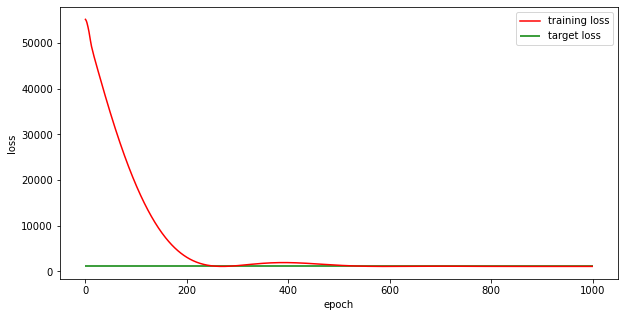

In [14]:
def plot_result(result,target):
    index = np.arange(len(result))
    fig, (ax1) = plt.subplots(1,1, figsize=(10,5))
    ax1.plot(index,result,label='training loss', c='red')
    ax1.hlines(y=target,xmin=0,xmax=1000,color='g',label='target loss')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    
    plt.show()
    return fig

result_plot = plot_result(result,target_loss)